# Time Series Forecasting with the Long Short-Term Memory Network in Python

- http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [1]:
%matplotlib inline

In [49]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import numpy as np

In [3]:
def parser(x):
    return datetime.strptime('190' + x, '%Y-%m')

In [4]:
series = read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [5]:
print(series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


In [6]:
type(series)

pandas.core.series.Series

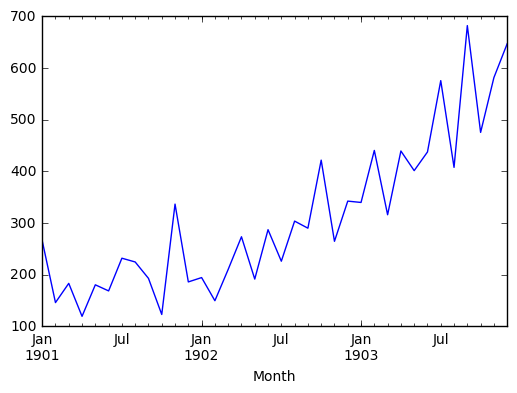

In [7]:
series.plot()

In [8]:
X = series.values
train, test = X[0:-12], X[-12:]

In [9]:
print(train.shape, test.shape)

(24,) (12,)


## Persistence Model Forecast

- 時系列予測のベースライン
- 前の値をそのまま次の値と予測する

RMSE: 136.761


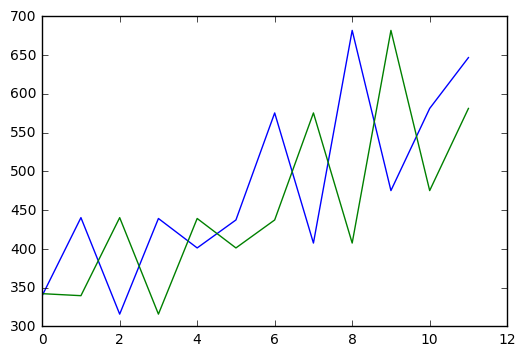

In [10]:
# trainを上書きしないための措置
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # 1つ前のデータを予測値とする
    predictions.append(history[-1])
    history.append(test[i])
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

plt.plot(test)
plt.plot(predictions)

## LSTM訓練データの準備

1. 時系列データ予測を教師あり学習の問題に変換
2. stationaryな時系列データ（トレンドを除去した時系列）に変換
3. 正規化

In [11]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame, Series
from pandas import concat

In [12]:
# 1. 時系列データを (X, y)の教師ありデータの形式に変換する
# (t-1)から(t)を予測する
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [13]:
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


In [14]:
# 2. トレンドを除去した定常なデータに変換
# 差分を取る
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [15]:
a = [1, 3, 8, 9, 12]
d = difference(a, 1)
print(d)
inverse = list()
for i in range(len(d)):
    value = inverse_difference(a, d[i], len(a) - i)
    inverse.append(value)
print(inverse)

0    2
1    5
2    1
3    3
dtype: int64
[3, 8, 9, 12]


In [16]:
differenced = difference(series, 1)
print(differenced.head())

inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series) - i)
    inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


In [17]:
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64

In [18]:
# 3. 正規化
# [-1, 1]にスケーリングする
print(X.shape)
X = X.reshape(len(X), 1)
print(X.shape)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)

(36,)
(36, 1)


In [19]:
scaled_X[:10]

array([[-0.47858539],
       [-0.90545584],
       [-0.77323618],
       [-1.        ],
       [-0.7831882 ],
       [-0.82512884],
       [-0.60014217],
       [-0.6260885 ],
       [-0.73875955],
       [-0.98720455]])

In [20]:
inverted_X = scaler.inverse_transform(scaled_X)
print(inverted_X[:10])

[[ 266. ]
 [ 145.9]
 [ 183.1]
 [ 119.3]
 [ 180.3]
 [ 168.5]
 [ 231.8]
 [ 224.5]
 [ 192.8]
 [ 122.9]]


In [51]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)

    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

## データの前処理まとめ

In [22]:
# load dataset
series = read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
print(supervised_values.shape)

# split data into train and test
train, test = supervised_values[0:-12], supervised_values[-12:]
print(train.shape, test.shape)

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

(35, 2)
(23, 2) (12, 2)


## LSTM

デフォルトでは、KerasのLSTMレイヤーは、1つのバッチ内のデータ間の状態を維持します。 データのバッチは、ネットワークの重みを更新する前に処理するパターンの数を定義するトレーニングデータセットの固定サイズの行数です。 バッチ間のLSTMレイヤの状態はデフォルトでクリアされるため、LSTMをステートフルにする必要があります。 これにより、reset_states（）関数を呼び出すことで、LSTM層の状態がクリアされる時期をきめ細かく制御することができます。

In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [24]:
print(train_scaled.shape, test_scaled.shape)

(23, 2) (12, 2)


In [26]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    # 各行がサンプル
    # 最後の列を予測する
    X, y = train[:, 0:-1], train[:, -1]

    # (samples, time step, features)
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    # statefulなのでバッチをまたいでも内部状態は維持される
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        # 各サンプルが時系列なのでshuffleせずに順番にバッチを読み込むことで過去の系列を利用する
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        # バッチをすべて読みこんだら新しいエポックが始まるので内部状態をリセットする
        model.reset_states()
    return model

In [72]:
lstm_model = fit_lstm(train_scaled, 1, 100, 4)

Epoch 1/1
23/23 [==============================] - 1s - loss: 0.2735     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2706     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2680     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2656     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2632     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2609     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2587     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2565     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2544     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2523     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2503     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2482     
Epoch 1/1
23/23 [==============================] - 0s - loss: 0.2462     
Epoch 1/1
23/23 [=====================

In [73]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]

In [74]:
train_scaled.shape

(23, 2)

In [75]:
# 訓練データを(samples, time step, features)に変換
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)

In [76]:
res = lstm_model.predict(train_reshaped, batch_size=1)

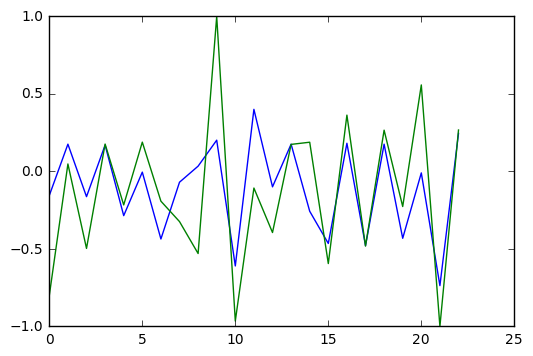

In [77]:
plt.plot(res)
plt.plot(train_scaled[:, 1])

In [78]:
# テストデータを順に予測していく
print(test_scaled.shape)
predictions = list()
for i in range(len(test_scaled)):
    # X:テスト入力  y:正解（変換後）
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    # LSTMによる予測
    yhat = forecast_lstm(lstm_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    predictions.append(yhat)
    # 変換前の正解を取得
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i + 1, yhat, expected))

(12, 2)
Month=1, Predicted=290.737143, Expected=339.700000
Month=2, Predicted=352.520235, Expected=440.400000
Month=3, Predicted=348.043555, Expected=315.900000
Month=4, Predicted=379.579204, Expected=439.300000
Month=5, Predicted=361.178842, Expected=401.300000
Month=6, Predicted=441.685051, Expected=437.400000
Month=7, Predicted=409.179155, Expected=575.500000
Month=8, Predicted=445.519161, Expected=407.600000
Month=9, Predicted=460.398994, Expected=682.000000
Month=10, Predicted=547.874918, Expected=475.300000
Month=11, Predicted=551.365354, Expected=581.300000
Month=12, Predicted=514.416241, Expected=646.900000


In [81]:
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 99.277


- Persistence ModelのRMSEは136.761なのでそれに比べるとLSTMを用いたRMSEは減少
- 訓練のepochを回しすぎると訓練データに過学習するのでテストデータおRMSEは悪化する

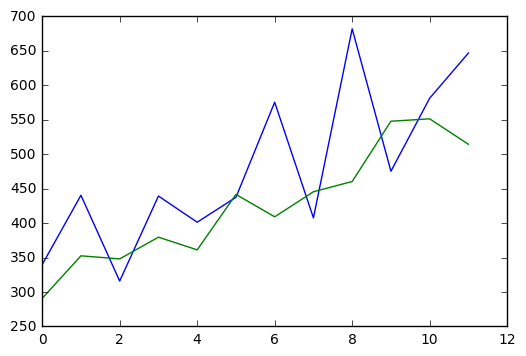

In [80]:
plt.plot(raw_values[-12:])
plt.plot(predictions)